In [8]:
import pandas as pd
from pandas import *
import subprocess
import os
from datetime import date
from datetime import timedelta
import sys
from sklearn.linear_model import ElasticNet 
from collections import OrderedDict
from sklearn.neighbors.kde import KernelDensity

import brewer2mpl
import pylab as pl
import matplotlib as plt
import matplotlib
import matplotlib.pyplot as plt
# import scipy as sc
# from scipy import stats
# from scipy.stats import norm
# from pylab import *
# from numpy import float64
from mpltools import style
from mpltools import special
# import statsmodels.api as sm
# from statsmodels.sandbox.regression.predstd import wls_prediction_std
# import statsmodels.formula.api as smf
# from statsmodels.formula.api import ols
# from sklearn import mixture
# import random
import random

plt.style.use('ggplot')

%matplotlib inline

# TODO: fix departure to impute historical average

## Initial problem
* ### Objective: predict units sold given a date (and associated weather), store, and item number
* ### Units are weather-sensitive items
* ### Test set + training set is a 3 year span of sales for Walmart
    * Test set includes days within $\pm$ 3 days of a major storm, which we'll call "stormy days"
    * Test set includes only days within the final year (?)
    * Test set is not all stormy days in that time period
    * Training set is all remaining days
* ### Other issues
    * There are sime missing values in weather, indicated by 'M' (there are also "trace" amounts indicated by 'T'). These need to be filled oin
    * The test set and training set are fundamentally different. The training set includes many days not qualified as "stormy days" whereas the test set does not
    * There may be other trends, such as time
    
### Plan
* View datasets
* Analysis of missingness ('M' and 'T' values)
* Imputation
* Categorize stormy days
* Look at sales trends by store, item, date (dataviz)
* Inspect 0-sales days
* Build features
* Run models

## Peak at datasets

### Weather set:

In [9]:
weather = read_csv('weather.csv')
weather.head(2)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3


### Training set

In [10]:
train = read_csv('train.csv')
train.head(2)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0


### Test set

In [11]:
test = read_csv('test.csv')
test.head(2)

,date,store_nbr,item_nbr
0,2013-04-01,2,1
1,2013-04-01,2,2


### plot of test set (blue), training set (red) over time histogram

In [12]:
def fix_date(x):
    x = x.split('-')
    return date(int(x[0]), int(x[1]), int(x[2]))

for df in [weather, test, train]:
    df.loc[:, 'date'] = df.loc[:, 'date'].apply(lambda x: fix_date(x))

In [13]:
date(2014,10,26) - date(2012,1,1)

datetime.timedelta(1029)

In [14]:
month_days = {1: 0,
            2: 31,
            3: 59,
            4: 90,
            5: 120,
            6: 151,
            7: 181,
            8: 212,
            9: 243,
            10: 273,
            11: 303,
            12: 334}

def convert_date(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + year*365 + month + day
    

train_dates = train.date.apply(lambda x: convert_date(x))

In [15]:
test_dates = test.date.apply(lambda x: convert_date(x))

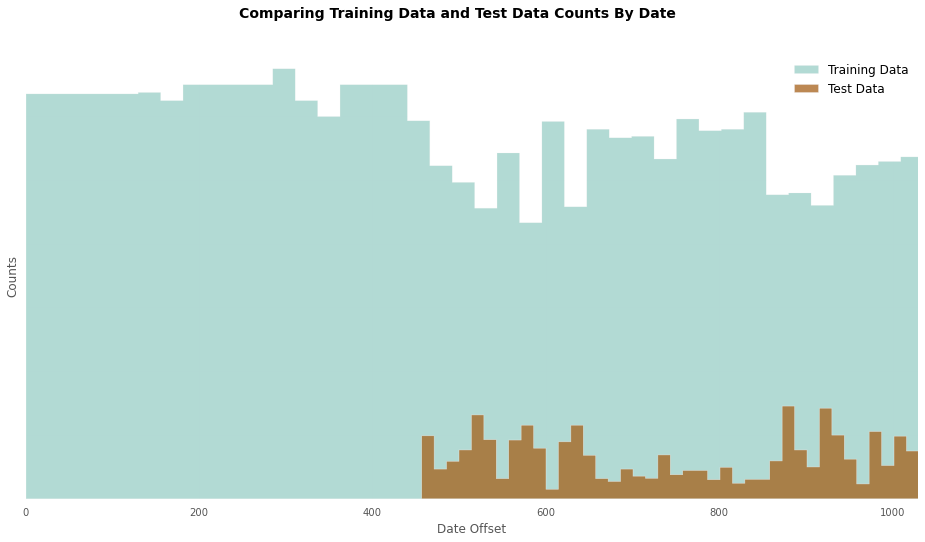

In [16]:
fig = plt.figure(figsize = (16,8)) 
ax = fig.add_subplot(1,1,1)
# x = np.arange(t.VPIP.min(),vpip.VPIP.max())
colors = brewer2mpl.get_map('BrBG','diverging',4).mpl_colors 


tr = plt.hist(train_dates, bins = 40, color = colors[3], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Training Data')
te = plt.hist(test_dates, bins = 40, color = colors[0], normed = False, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.75, label = 'Test Data')
for label in ax.get_xticklines():
    label.set_visible(False)
for label in ax.get_yticklines():
    label.set_visible(False)
for label in ax.get_yticklabels():
    label.set_visible(False)  
x = plt.xlim([0,1029])
plt.xlabel('Date Offset')
plt.ylabel('Counts')
ax.legend(loc = 'best')
plt.suptitle('Comparing Training Data and Test Data Counts By Date', 
             fontsize = 14, fontweight = 'bold')
plt.show()

### Key to join weather station with store

In [17]:
key = read_csv('key.csv', index_col = 'store_nbr')
key.head(2)

,station_nbr
store_nbr,
1,1
2,14


### Sample submission - this is what the final output needs to look like

In [18]:
sample_submit = read_csv('sampleSubmission.csv', index_col = 'id')
sample_submit.head(2)

,units
id,
2_1_2013-04-01,0
2_2_2013-04-01,0


### Initial prep of datasets
* Join key with test and trianing set
* Add store_item_date id to test set
* Convert dates to python dates

In [19]:
train = train.merge(key, left_on = 'store_nbr', right_index = True)
test = test.merge(key, left_on = 'store_nbr', right_index = True)

In [20]:
test.loc[:, 'id'] = test.store_nbr.apply(lambda x: str(x)) + '_' +\
                    test.item_nbr.apply(lambda x: str(x)) + '_' +\
                    test.date.apply(lambda x: str(x))

In [21]:
test.head(2)

,date,store_nbr,item_nbr,station_nbr,id
0,2013-04-01,2,1,14,2_1_2013-04-01
1,2013-04-01,2,2,14,2_2_2013-04-01


### Plot of station counts by store

In [22]:
station_counts = train[['station_nbr','store_nbr']].drop_duplicates().groupby('station_nbr').count()
station_counts = [station_counts.loc[c][0] if c in station_counts.index else 0 for c in np.arange(1,21,1)]

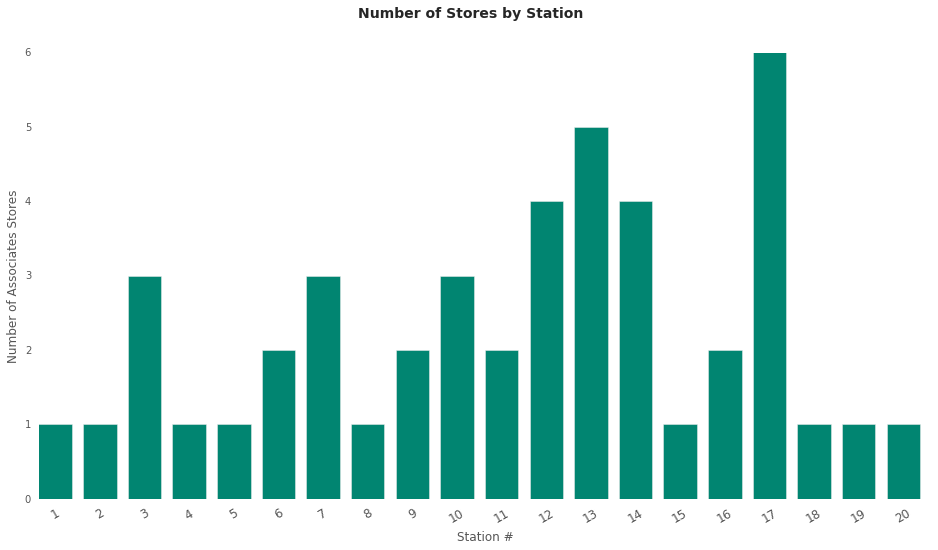

In [23]:
fig = plt.figure(figsize = (16,8))
ax = plt.subplot(111)

x = np.arange(1,21,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, station_counts, width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,x, rotation = 30, fontsize = 12)
plt.xlabel('Station #')
plt.ylabel('Number of Associates Stores')
plt.suptitle('Number of Stores by Station', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])
plt.show()


### Station 5 is not associated with any stores so we can throw it away

In [24]:
print test[['date','station_nbr']].groupby('station_nbr').count().index

Int64Index([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [25]:
print train[['date','station_nbr']].groupby('station_nbr').count().index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')


In [26]:
train = train[train.station_nbr != 5]
weather = weather[weather.station_nbr != 5]

# Weather dataset

## There are 'T' values for trace, meaning small amount. We'll replace that with half the smallest non-zero value for that column
* ### First call unix tools to see which columns have 'T' values

In [27]:
pwd = os.getcwd()

trace = {}
for i, col in enumerate(weather.columns):
    cmd = "cut -d, -f" + str(i+1) + " weather.csv | grep 'T' | wc -l"
    ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    output = ps.communicate()[0].replace('\n','')

    trace[col] = float("{:.2f}".format(float(output) / len(weather)))
    
trace = DataFrame.from_dict(trace, orient = 'index')
trace.columns = ['Proportion Trace']
trace[trace['Proportion Trace'] > 0]

,Proportion Trace
snowfall,0.02
preciptotal,0.12
codesum,0.10


### Codesum T is just a code (not trace). Get minimum for snowfall and preciptotal and replace 'T' with half that value

In [28]:
for col in ['snowfall','preciptotal']:
    # temporarily replace with -1
    v = weather.loc[:, col].apply(lambda x: -1. if str(x).strip() in ['M', 'T'] else float(x))
    # replace 'T' with the minimum non-zero value
    weather.loc[:, col] = weather.loc[:, col].apply(lambda x: v[v > 0].min() if str(x).strip() == 'T' else x)

In [29]:
print len(weather[weather.snowfall == 'T'])
print len(weather[weather.preciptotal == 'T'])

0
0


## Call unix tools from python to perform analysis of missingness

In [30]:
pwd = os.getcwd()

missing = {}
for i, col in enumerate(weather.columns):
    cmd = "cut -d, -f" + str(i+1) + " weather.csv | grep 'M' | wc -l"
    ps = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    output = ps.communicate()[0].replace('\n','')

    missing[col] = float("{:.2f}".format(float(output) / len(weather)))
    
missing = DataFrame.from_dict(missing, orient = 'index')
missing.columns = ['Proportion Missing']

* ### Departure is missing 56% of values. This may be unusable but if we can get data from surrounding days we can recover a lot of the average temps
* ### Snowfall is missing 35% of values. This could be a key column so we should take more care in imputing
* ### The others are missing 8% of fewer.

In [31]:
m = missing[missing['Proportion Missing'] > 0].sort('Proportion Missing', ascending = False)
m

,Proportion Missing
depart,0.59
snowfall,0.37
sealevel,0.09
tavg,0.07
heat,0.07
cool,0.07
wetbulb,0.06
stnpressure,0.05
tmin,0.05
tmax,0.05


In [32]:
len(m.iloc[:,0].values)

15

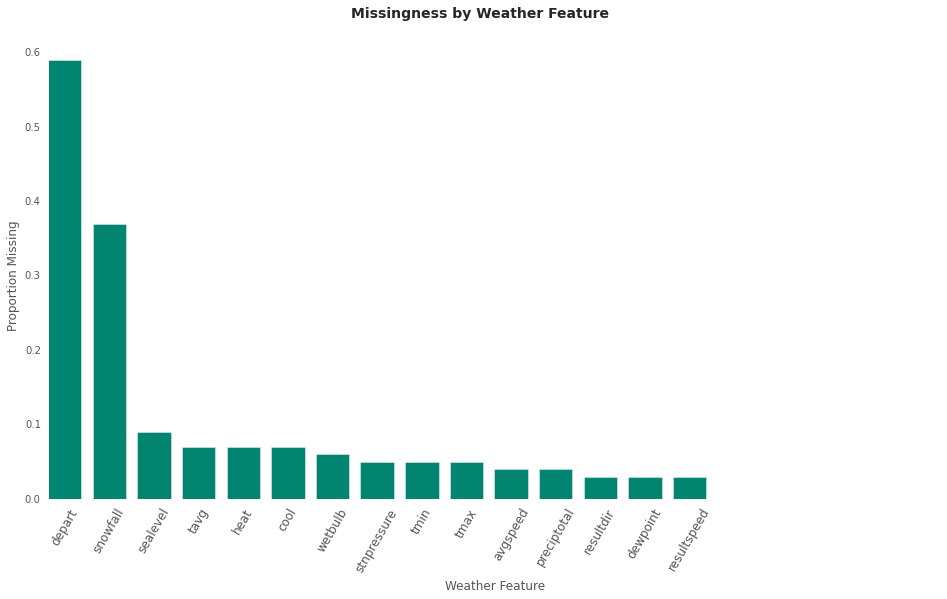

In [33]:
fig = plt.figure(figsize = (16,8))
ax = plt.subplot(111)

# x = np.arange(1,len(m.index)+1,1)
x = np.arange(1,len(m.index)+1,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, m.iloc[:, 0], width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,m.index, rotation = 60, fontsize = 12)
plt.xlabel('Weather Feature')
plt.ylabel('Proportion Missing')
plt.suptitle('Missingness by Weather Feature', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])
plt.show()

list of columns to impute (excludes departure and snowfall, for now), plus store_nbr

In [34]:
icols = ['station_nbr']
icols.extend(list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])))
print icols

['station_nbr', 'tavg', 'resultdir', 'stnpressure', 'tmin', 'wetbulb', 'dewpoint', 'avgspeed', 'tmax', 'sealevel', 'heat', 'preciptotal', 'resultspeed', 'cool']


In [35]:
heatcols = ['station_nbr']
heatcols.extend(list(missing[missing['Proportion Missing'] > 0].index))

### Look at which columns are missing by which store (proportion with blank cells == 0)

In [36]:
mreplace = weather.copy()
for c in heatcols:
    mreplace.loc[:, c] = mreplace.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
station_missing = mreplace.groupby('station_nbr').count()

scounts = weather[['station_nbr','date']].groupby('station_nbr').count()
scounts.columns = ['total']
station_missing = station_missing.merge(scounts, left_index = True, right_index = True)
for c in station_missing.columns[:-1]:
    station_missing.loc[:, c]  = (1 - station_missing.loc[:, c] / station_missing.loc[:, 'total']).apply(lambda x: "{:.2f}".format(x) if x > 0 else '')
station_missing.drop('total', 1)

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
station_nbr,,,,,,,,,,,,,,,,,,,
1,,0.00,0.00,0.01,1.00,0.01,0.01,0.01,0.01,,,,1.00,0.00,0.00,0.01,0.00,0.00,0.00
2,,0.00,0.00,0.01,0.04,0.01,0.02,0.01,0.01,,,,0.01,0.00,0.01,0.01,0.00,0.00,0.00
3,,0.00,0.00,0.01,0.04,,0.00,0.01,0.01,,,,0.00,0.00,0.00,0.00,,,0.00
4,,0.00,0.00,0.01,0.04,0.01,0.01,0.01,0.01,,,,0.00,0.00,0.00,0.02,0.01,0.01,0.00
6,,0.00,0.00,0.01,0.04,,0.00,0.01,0.01,,,,0.01,0.00,0.00,0.00,,,0.00
7,,0.03,0.03,0.04,1.00,0.04,0.04,0.04,0.04,,,,0.06,0.00,0.00,0.04,0.00,0.00,0.00
8,,0.01,0.01,0.45,1.00,0.05,0.06,0.45,0.45,,,,1.00,0.00,0.01,1.00,0.03,0.03,0.00
9,,0.01,0.01,0.02,1.00,0.02,0.06,0.02,0.02,,,,0.98,0.00,0.01,0.01,0.00,0.00,0.00
10,,,,0.01,1.00,,0.00,0.01,0.01,,,,1.00,0.00,0.00,0.00,,,0.00


### Heatmap of missingness

In [37]:
def heat_vals(weather):
    mreplace = weather.copy()
    for c in heatcols:
        mreplace.loc[:, c] = mreplace.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
        
    station_missing = mreplace.groupby('station_nbr').count()
    
    scounts = weather[['station_nbr','date']].groupby('station_nbr').count()
    scounts.columns = ['total']
    station_missing = station_missing.merge(scounts, left_index = True, right_index = True)
    station_missing = station_missing.drop('date', 1)
    for c in station_missing.columns:
        station_missing.loc[:, c]  = (1 - station_missing.loc[:, c] / station_missing.loc[:, 'total']).apply(lambda x: float(x))
    station_missing = station_missing.drop('total', 1)

    # get row/column names
    column_labels = list(OrderedDict.fromkeys([int(i[0]) for i in station_missing.stack().index]))
    row_labels = list(OrderedDict.fromkeys([i[1] for i in station_missing.stack().index]))

    return column_labels, row_labels, station_missing.values

In [38]:
def heatmap((column_labels, row_labels, heat)):
    fig = plt.figure(figsize = (16,12))
    ax = plt.subplot(111)

    heatmap = ax.pcolor(heat, cmap=plt.cm.Blues)

    ax.set_xticks(np.arange(heat.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(heat.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_labels, minor=False, rotation = 60)
    ax.set_yticklabels(column_labels, minor=False)

    plt.xlim([0,len(row_labels)])

    # plt.xticks(x+width/2,m.index, rotation = 60, fontsize = 12)

    # for label in ax.get_xticklines():
    #     label.set_visible(False)
    for label in ax.get_yticklines():
        label.set_visible(False)
    plt.xlabel('Feature')
    plt.ylabel('Station Number')

    plt.colorbar(heatmap, label = 'Proportion Missing')

    plt.suptitle('Data Missingness by Store and Weather Feature', 
                 fontsize = 14, fontweight = 'bold')
    plt.show()


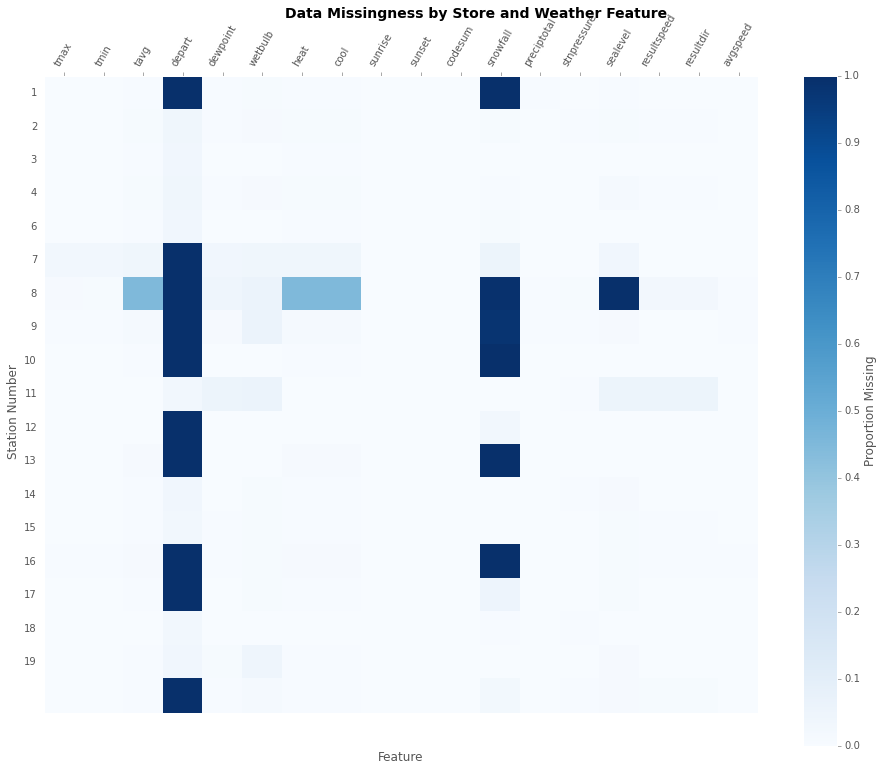

In [39]:
heatmap(heat_vals(weather))

### For all except snowfall and departure, impute with the average of $\pm$ 3 days from the date for that station

make all the cols floats

In [40]:
for c in [c for c in icols if c != 'store_nbr']:
    weather.loc[:, c] = weather.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))

In [41]:
# pm_weather takes a row from a df, a dict w
# and number of days offset, and adds a row to d
# for each date and corresponding values from the 
# df row
# ultimately, this lets us average the values
# from a window around a target day

def pm_weather(row, w, d, icols):
    # current date
    currdate = row.date
    
    # all values for the columns we want
    vals = list(row.loc[icols].values)
    
    n = len(w)
    # make a row for +/- 3 days from this current date/station
    for day in range(-d, d+1):
        w[day + n + d] = [currdate + timedelta(days = day)]
        w[day + n + d].extend(vals)
    
    return w

In [42]:
# make a df of all +/- 3 day windows
wimpute = {}

for i in weather.index:
    wimpute = pm_weather(weather.loc[i, :], wimpute, 3, icols)
    
impute = DataFrame.from_dict(wimpute, orient = 'index')
wcols = ['date']
wcols.extend(icols)
impute.columns = wcols
impute.head(2)

,date,station_nbr,tavg,resultdir,stnpressure,tmin,wetbulb,dewpoint,avgspeed,tmax,sealevel,heat,preciptotal,resultspeed,cool
0,2011-12-29,1,42,20,29.78,31,40,36,4.6,52,29.92,23,0.05,3.6,0
1,2011-12-30,1,42,20,29.78,31,40,36,4.6,52,29.92,23,0.05,3.6,0


In [43]:
station_date_means = impute.groupby(['date','station_nbr']).mean()
station_date_means.head(2)

tavg  resultdir  stnpressure  tmin  wetbulb  dewpoint  \
date       station_nbr                                                          
2011-12-29 1              42         20        29.78    31       40        36   
           2              41         23        28.82    33       39        37   

                        avgspeed  tmax  sealevel  heat  preciptotal  \
date       station_nbr                                                
2011-12-29 1                 4.6    52     29.92    23         0.05   
           2                11.3    48     29.91    24         0.07   

                        resultspeed  cool  
date       station_nbr                     
2011-12-29 1                    3.6     0  
           2                    9.1     0

In [44]:
# for each column to impute
for col in list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])):
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (weather.loc[i, 'date'], weather.loc[i, 'station_nbr'])
            weather.loc[i, col] = station_date_means.loc[idx, col]

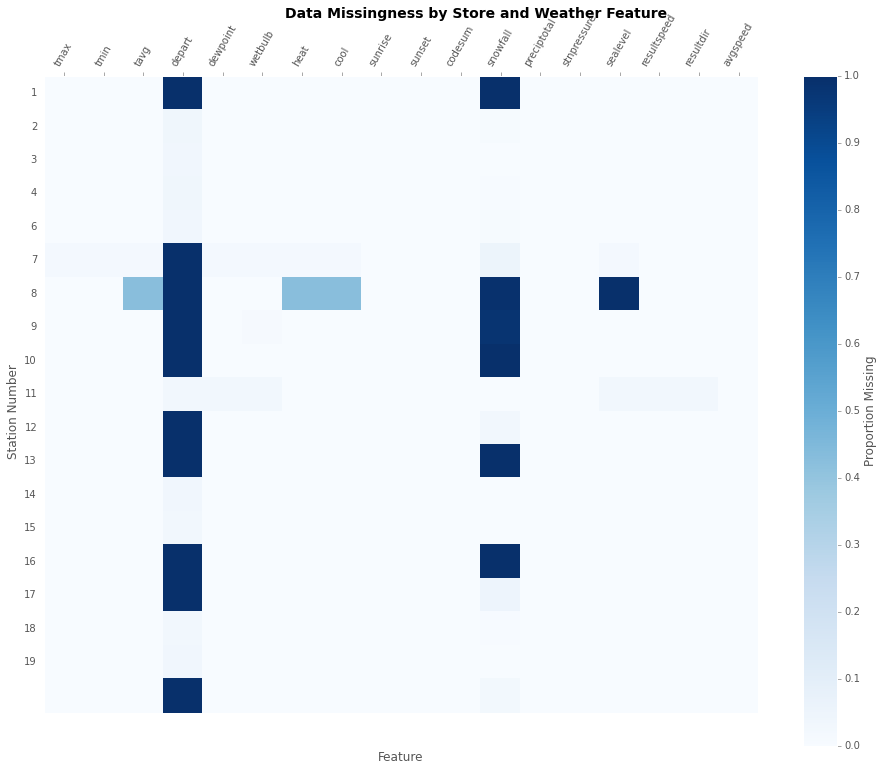

In [45]:
heatmap(heat_vals(weather))

### Catch the ones with missing values after $\pm$ 3 with increasing $\pm$ values then inspect the ones still missing

In [46]:
wimpute = {}

for i in weather.index:
    wimpute = pm_weather(weather.loc[i, :], wimpute, 15, icols)
    
impute = DataFrame.from_dict(wimpute, orient = 'index')
wcols = ['date']
wcols.extend(icols)
impute.columns = wcols
station_date_means = impute.groupby(['date','station_nbr']).mean()

# for each column to impute
for col in list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])):
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (weather.loc[i, 'date'], weather.loc[i, 'station_nbr'])
            weather.loc[i, col] = station_date_means.loc[idx, col]

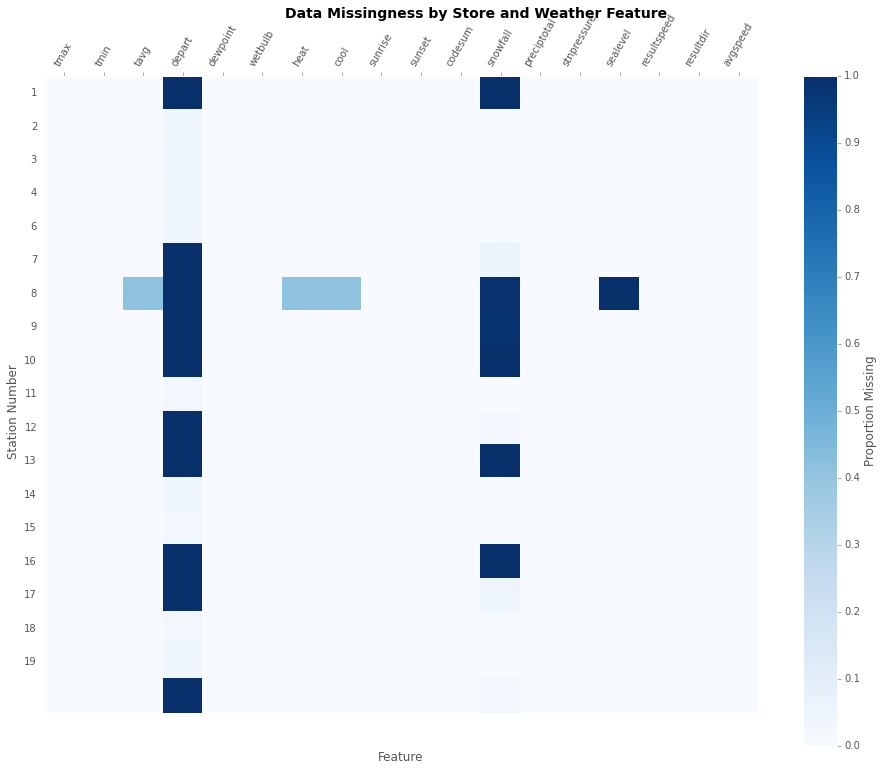

In [47]:
heatmap(heat_vals(weather))

### replace others with store/month mean

In [48]:
storemonth = weather.loc[:, wcols]
storemonth.loc[:, 'date'] = storemonth.date.apply(lambda x: (x.month, x.weekday()))
storemonth = storemonth.groupby(['date','station_nbr']).mean()
storemonth.head(2)

tavg  resultdir  stnpressure       tmin    wetbulb  \
date   station_nbr                                                            
(1, 0) 1            34.076923  24.000000    29.836154  24.153846  29.461538   
       2            30.230769  24.461538    28.863846  20.692308  27.384615   

                     dewpoint   avgspeed       tmax   sealevel       heat  \
date   station_nbr                                                          
(1, 0) 1            19.846154   7.015385  43.615385  30.004615  30.923077   
       2            19.615385  10.923077  39.307692  29.967692  34.769231   

                    preciptotal  resultspeed  cool  
date   station_nbr                                  
(1, 0) 1               0.064615     5.230769     0  
       2               0.097692     8.807692     0

In [49]:
for col in list(missing[missing['Proportion Missing'] > 0].index.drop(['depart','snowfall'])):
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (
                    (\
                     weather.loc[i, 'date'].month, \
                     weather.loc[i, 'date'].weekday() \
                    ), \
                     weather.loc[i, 'station_nbr'])
            try:
                weather.loc[i, col] = storemonth.loc[idx, col]
            except:
                pass

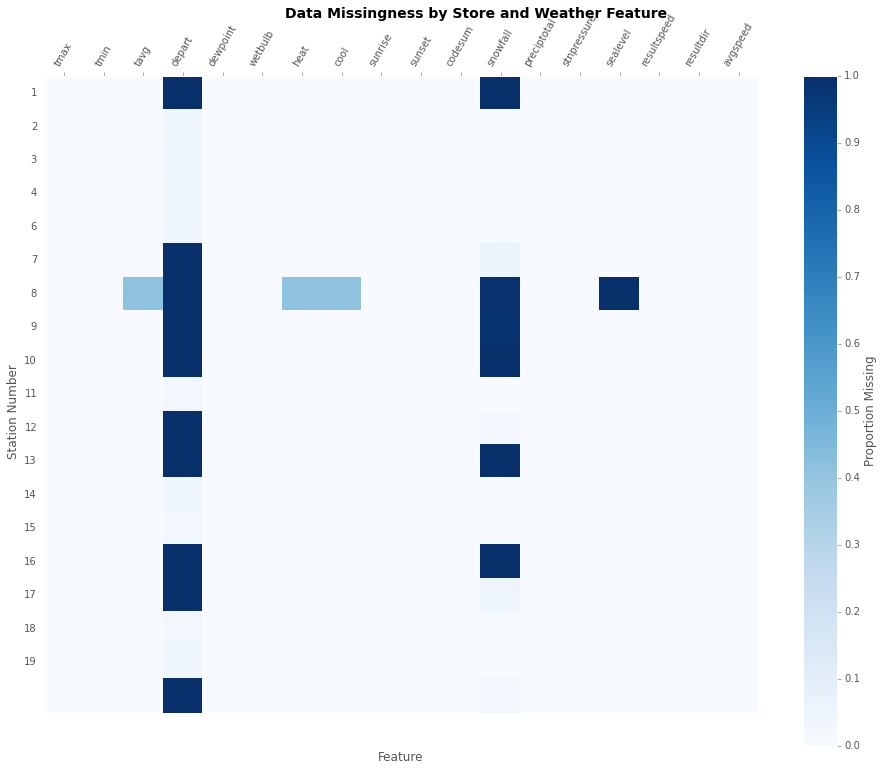

In [50]:
heatmap(heat_vals(weather))

### we can do an Elastic Net regression on tmin/tmax predicting tavg, to get imputed values for those

In [51]:
tavg = read_csv('weather.csv')[['tmin','tmax','tavg']]
for c in tavg.columns:
    tavg.loc[:, c] = tavg.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
tavg = tavg.dropna()

In [52]:
en = ElasticNet()
en.fit(tavg[['tmin','tmax']].values, tavg[['tavg']].values)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
for w in weather.index:
    if np.isnan(weather.loc[w, 'tavg']):
        weather.loc[w, 'tavg'] = en.predict(weather.loc[w, ['tmin','tmax']])[0]

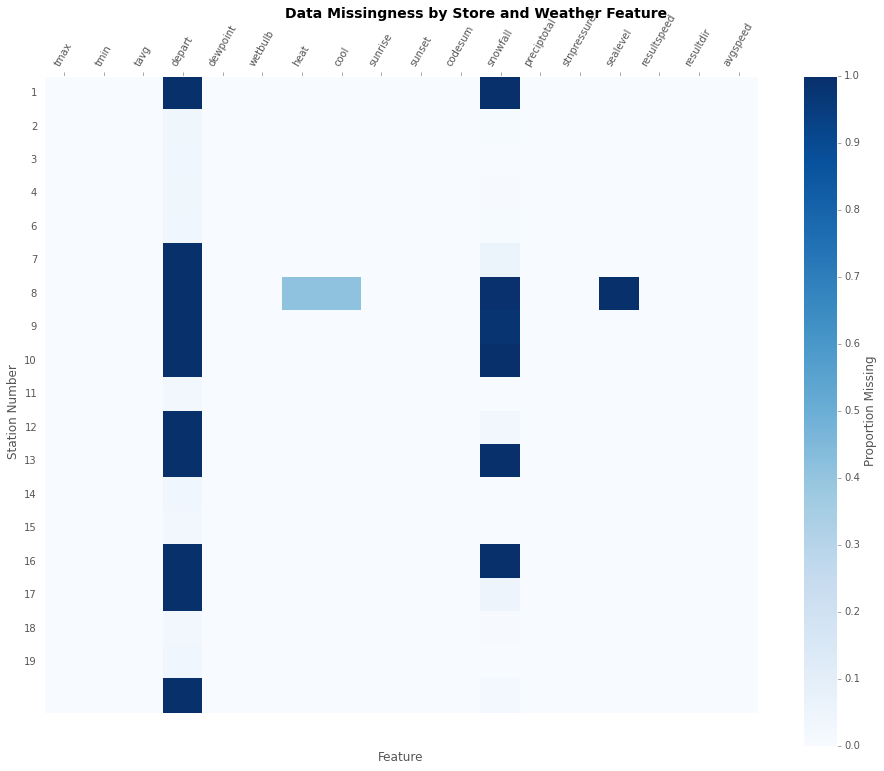

In [54]:
heatmap(heat_vals(weather))

# Snowfall and preciptotal

## Is there any pattern to missingness?

### Date (no pattern):

In [55]:
def missingness_plot(feat):
    temp = weather[weather[feat] == 'M'][['date', feat]]
    missing_dates = temp.date.apply(lambda x: convert_date(x)).values
    
    fig = plt.figure(figsize = (16,9))
    ax = plt.subplot(111)
    plt.suptitle('Kernel Density Estimate for ' + feat + ' Missingness over Time',
                 fontweight = 'bold', color = '#262626', fontsize = 16)

    missing_dates = missing_dates.reshape(-1, 1)

    kde = KernelDensity(bandwidth=2).fit(missing_dates)
    x = np.linspace(missing_dates.min(), missing_dates.max(), 100).reshape(-1, 1)
    density = np.exp(kde.score_samples(x))

    plt.plot(x, density, linewidth = 5, label = 'Missingness Density', color = colors[0])
    plt.plot(missing_dates, abs(np.random.rand(len(missing_dates), 1)/20000), 'ok', \
             ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')
    plt.vlines((test.date.min() - train.date.min()).days, 0, max(density), linestyles = '--', label = 'Training Set Start')


#     plt.ylim(0, .0016)
    plt.xlim([0, 1029])

    plt.xlabel('Date Offset')
    plt.ylabel("Density")

    xaxis = [temp.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
    xvals = np.arange(0,1030,45)
    plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

    for label in ax.get_xticklines():
        label.set_visible(False)
    for label2 in ax.get_yticklines():
        label2.set_visible(False)

    ax.legend(loc = 'best')

    plt.show()

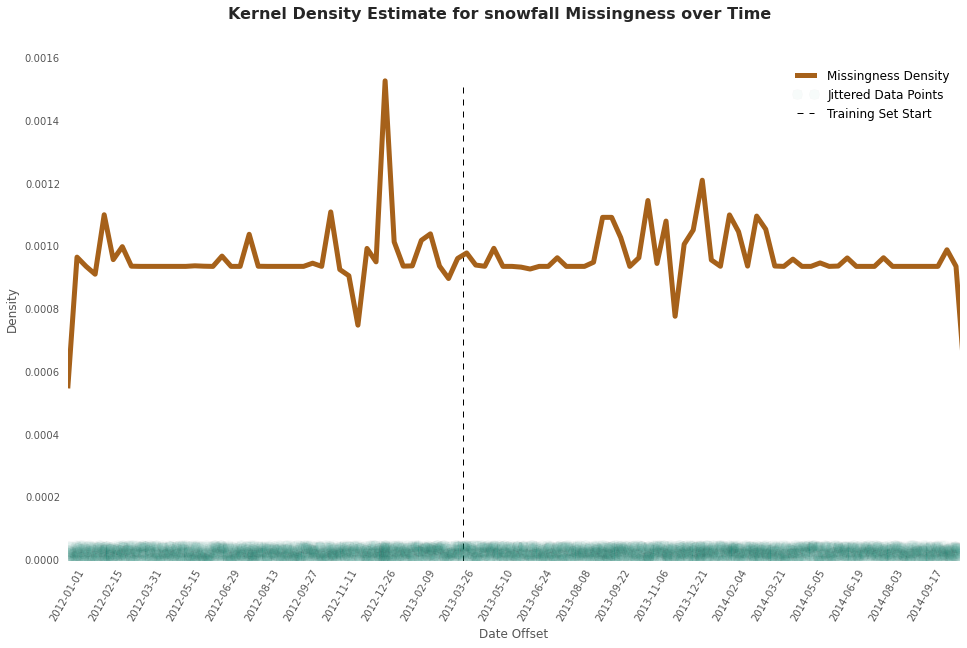

In [56]:
missingness_plot('snowfall')

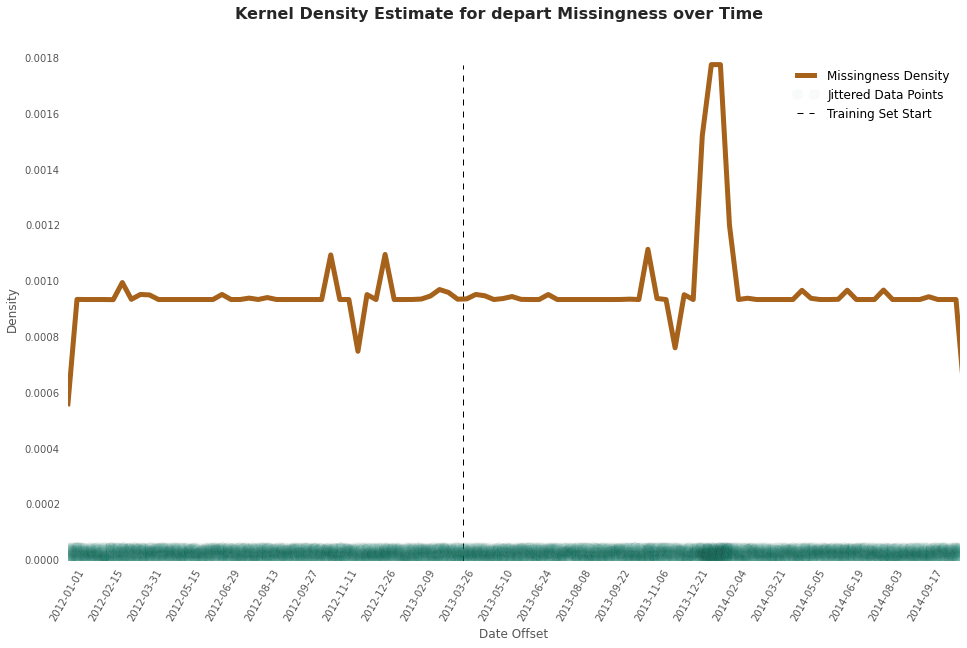

In [57]:
missingness_plot('depart')

In [58]:
stationcounts = weather[['station_nbr','date']].groupby('station_nbr').count()
stationcounts.columns = ['total']
for wtype in ['snowfall','depart']:
    stations = weather[weather[wtype] == 'M'][['station_nbr','depart']].groupby('station_nbr').count()
    temp = weather[weather[wtype] == 'M'][['station_nbr','depart']]
    if wtype == 'snowfall':
        stationcounts['snow'] = temp.station_nbr.apply(lambda x: x).value_counts()
    else:
        stationcounts['depart'] = temp.station_nbr.apply(lambda x: x).value_counts()
stationcounts.loc[:, 'snow'] = stationcounts.loc[:, 'snow'].apply(lambda x: float(x)) / stationcounts.total
stationcounts.loc[:, 'depart'] = stationcounts.loc[:, 'depart'].apply(lambda x: float(x)) / stationcounts.total        

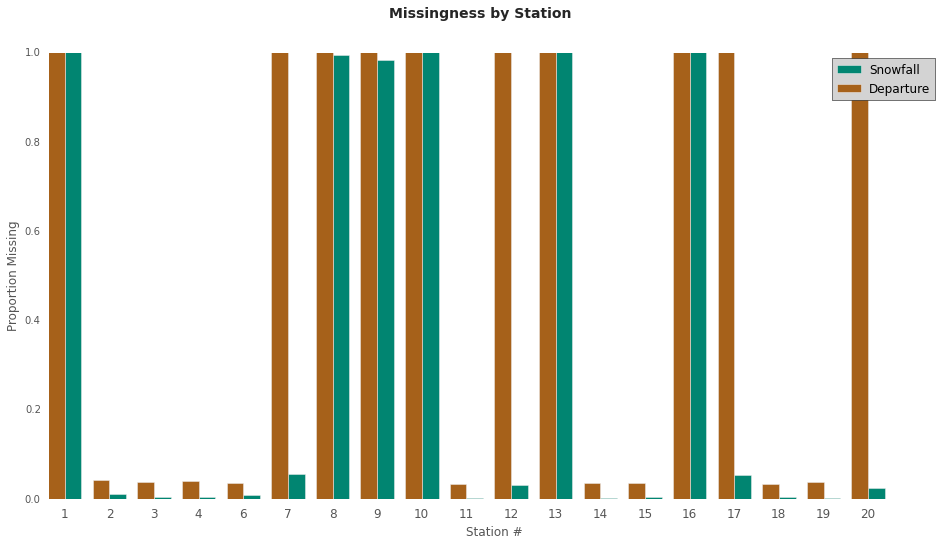

In [59]:
fig = plt.figure(figsize = (16, 8))
ax = plt.subplot(111)

# x = np.arange(1,len(m.index)+1,1)
x = np.arange(1,len(stationcounts.index)+1,1)
width = 0.75

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x+width/2, stationcounts.iloc[:, 1], width/2, color = colors[3], label = 'Snowfall')
bar2 = plt.bar(x, stationcounts.iloc[:, 2], width/2, color = colors[0], label = 'Departure')

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,[int(i) for i in stationcounts.index], fontsize = 12)
plt.xlabel('Station #')
plt.ylabel('Proportion Missing')
plt.suptitle('Missingness by Station', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 21])

legend = ax.legend(loc = 'best')
legend = plt.legend(frameon = 2)
frame = legend.get_frame()
frame.set_color('lightgray')
frame.set_edgecolor('black') 

plt.show()

### several stations either don't or infrequently report snowfall and departure

In [60]:
stationcounts[np.logical_and(stationcounts.snow > 0.75, stationcounts.depart > 0.5)]

,total,snow,depart
station_nbr,,,
1,1035,1.000000,1
8,1035,0.995169,1
9,1035,0.982609,1
10,1035,1.000000,1
13,1035,1.000000,1
16,1035,1.000000,1


In [61]:
no_snow_depart = list(stationcounts[np.logical_and(stationcounts.snow > 0.75, stationcounts.depart > 0.5)].index)
no_snow_depart

[1.0, 8.0, 9.0, 10.0, 13.0, 16.0]

### replace departure with historical average (temperate average minus departure) and impute with that, then replace that after

In [62]:
for c in [c for c in ['snowfall','depart'] if c != 'store_nbr']:
    weather.loc[:, c] = weather.loc[:, c].apply(lambda x: float('nan') if x == 'M' else float(x))
weather.loc[:, 'depart'] = weather.tavg - weather.depart

In [63]:
# make a df of all +/- 3, 5, 15 day windows
for numdays in [3, 5, 15]:
    wimpute = {}
    for i in weather.index:
#         if weather.loc[i, 'station_nbr'] not in no_snow_depart:
        wimpute = pm_weather(weather.loc[i, :], wimpute, numdays, ['station_nbr','snowfall','depart'])

    impute = DataFrame.from_dict(wimpute, orient = 'index')
    wcols = ['date']
    wcols.extend(['station_nbr','snowfall','depart'])
    impute.columns = wcols
    impute.head(2)
    station_date_means = impute.groupby(['date','station_nbr']).mean()
    station_date_means.head(2)

    # for each column to impute
    for col in ['depart','snowfall']:
        # for each cell
        for i in weather.index:
            # if it's M replace with the station_date_mean value
            if np.isnan(weather.loc[i, col]): #and \
                    #weather.loc[i, 'station_nbr'] not in no_snow_depart:
                idx = (weather.loc[i, 'date'], weather.loc[i, 'station_nbr'])
                weather.loc[i, col] = station_date_means.loc[idx, col]

In [64]:
storemonth = weather[['station_nbr','snowfall','depart','date']]
storemonth.loc[:, 'date'] = storemonth.date.apply(lambda x: (x.month, x.weekday()))
storemonth = storemonth.groupby(['date','station_nbr']).mean()
storemonth.head(2)

for col in ['snowfall','depart']:
    # for each cell
    for i in weather.index:
        # if it's M replace with the station_date_mean value
        if np.isnan(weather.loc[i, col]):
            idx = (
                    (\
                     weather.loc[i, 'date'].month, \
                     weather.loc[i, 'date'].weekday() \
                    ), \
                     weather.loc[i, 'station_nbr'])
            try:
                weather.loc[i, col] = storemonth.loc[idx, col]
            except:
                pass

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Dealing with snowfall

* If tmin is over 32, for all intents and purposes, there is no snow

In [65]:
for tmin in np.arange(20, 40, 2):
    print tmin, weather[weather.tmin > tmin].snowfall.apply(lambda x: float('nan') if x == 'M' else float(x)).dropna().mean()

20 0.0227482027136
22 0.0177997227997
24 0.0151867063026
26 0.0122044554324
28 0.00753065729235
30 0.0040624386688
32 0.00121092164028
34 0.000295645645646
36 0.000190121155638
38 0.000168843734881


In [66]:
for i in weather.index:
    if weather.loc[i, 'snowfall'] == 'M' and weather.loc[i, 'tmin'] > 32:
        weather.loc[i, 'snowfall'] = 0

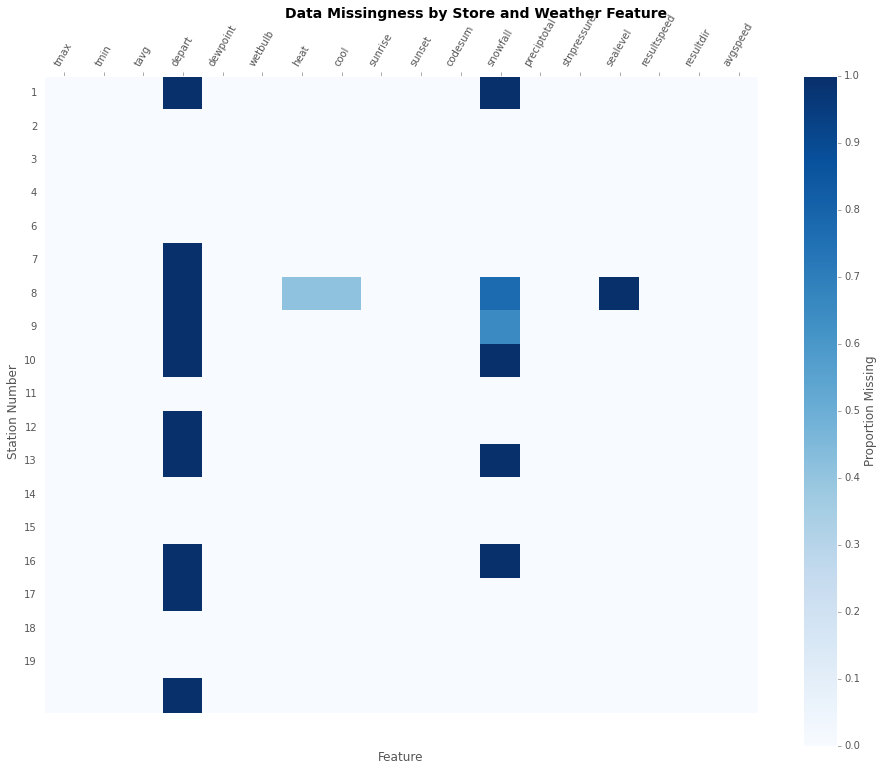

In [67]:
heatmap(heat_vals(weather))

### replace the departure back with average minus historical

In [68]:
weather.loc[:, 'depart'] = weather.tavg - weather.depart

# Find days with proximity to stormy days

### stacked bar with each proximity getting a color?

In [69]:
# weather.loc[:, 'codesum'] = weather.loc[:, 'codesum'].apply(lambda x: x.strip().split(' '))
weather.loc[:, 'snow_codes'] = weather.codesum.apply(lambda x: 1 if 'SN' in x or 'SG' in x else 0)
weather.loc[:, 'rain_codes'] = weather.codesum.apply(lambda x: 1 if 'SN' in x or 'RA' in x else 0)
snowdays = list(weather[np.logical_and(weather.snow_codes == 1, weather.snowfall >= 2)].index)
raindays = list(weather[np.logical_and(weather.rain_codes == 1, weather.preciptotal >= 1)].index)

stormydays = snowdays
stormydays.extend(raindays)
stormydays = list(set(stormydays))

weather.loc[stormydays, 'extreme'] = 1

weather_events = {}

for w in weather[weather.extreme == 1].index:
    station = weather.loc[w, 'station_nbr']
    for i in [i for i in range(-3, 4) if i != 0]:
        curr_date = weather.loc[w, 'date'] + timedelta(days = i)
        
        if i not in weather_events:
            weather_events[i] = []
        
        weather_events[i].append(str(station) + '_' + str(curr_date))

weather.loc[:, 'extreme'] = weather.loc[:, 'extreme'].apply(lambda x: 0 if np.isnan(x) else 1)
weather['store_date'] = weather.station_nbr.apply(lambda x: str(x)) + '_' + weather.date.apply(lambda x: str(x))
for i in [i for i in range(-3, 4) if i != 0]:
    weather.loc[:, 'ext_' + str(i)] = weather.store_date.apply(lambda x: 1 if x in weather_events[i] else 0)
weather = weather.drop('store_date', 1)

weather['all_extreme'] = weather[['extreme','ext_-3','ext_-2','ext_-1','ext_1','ext_2','ext_3']].sum(axis = 1)

In [70]:
prox = weather[['date','station_nbr','ext_-3','ext_-2','ext_-1','extreme','ext_1','ext_2','ext_3']]

In [71]:
prox.head(2)

,date,station_nbr,ext_-3,ext_-2,ext_-1,extreme,ext_1,ext_2,ext_3
0,2012-01-01,1,0,0,0,0,0,0,0
1,2012-01-01,2,0,0,0,0,0,0,0


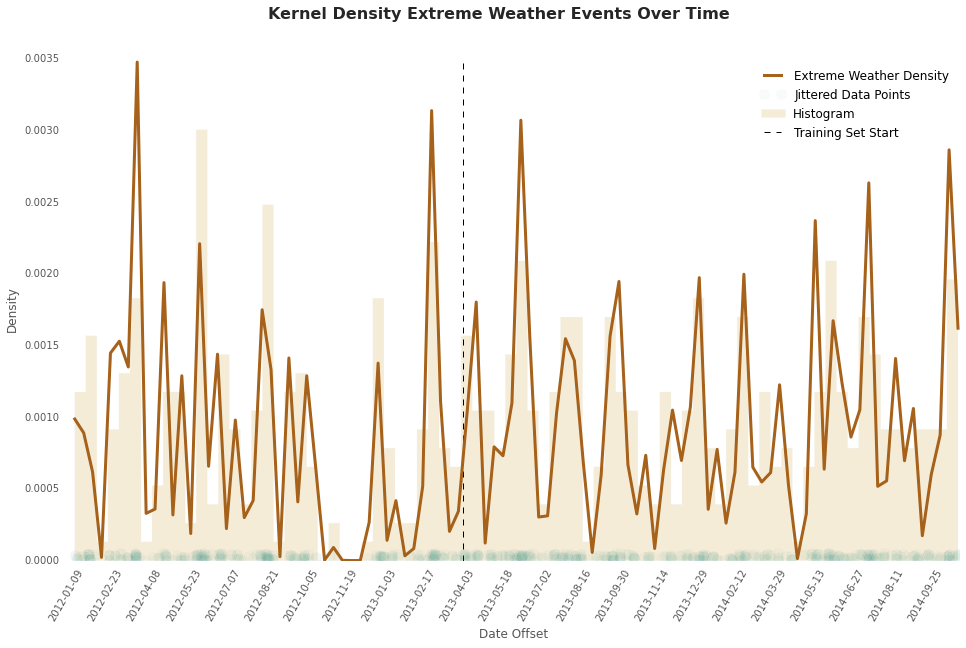

In [73]:
daily_ext = prox[prox.extreme == 1][['date','extreme']]
dates_ext = daily_ext.date.apply(lambda x: convert_date(x)).values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Kernel Density Extreme Weather Events Over Time',
             fontweight = 'bold', color = '#262626', fontsize = 16)

dates_ext = dates_ext.reshape(-1, 1)

kde = KernelDensity(bandwidth=2).fit(dates_ext)
x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
density = np.exp(kde.score_samples(x))

plt.plot(x, density, linewidth = 3, label = 'Extreme Weather Density', color = colors[0])
plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
         ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')
plt.vlines((test.date.min() - train.date.min()).days, 0, max(density), linestyles = '--', label = 'Training Set Start')
plt.hist(dates_ext, bins = 80, color = colors[1], normed = True, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')

#     plt.ylim(0, .0016)
plt.xlim([0, 1029])

plt.xlabel('Date Offset')
plt.ylabel("Density")

xaxis = [daily_ext.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
xvals = np.arange(0,1030,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

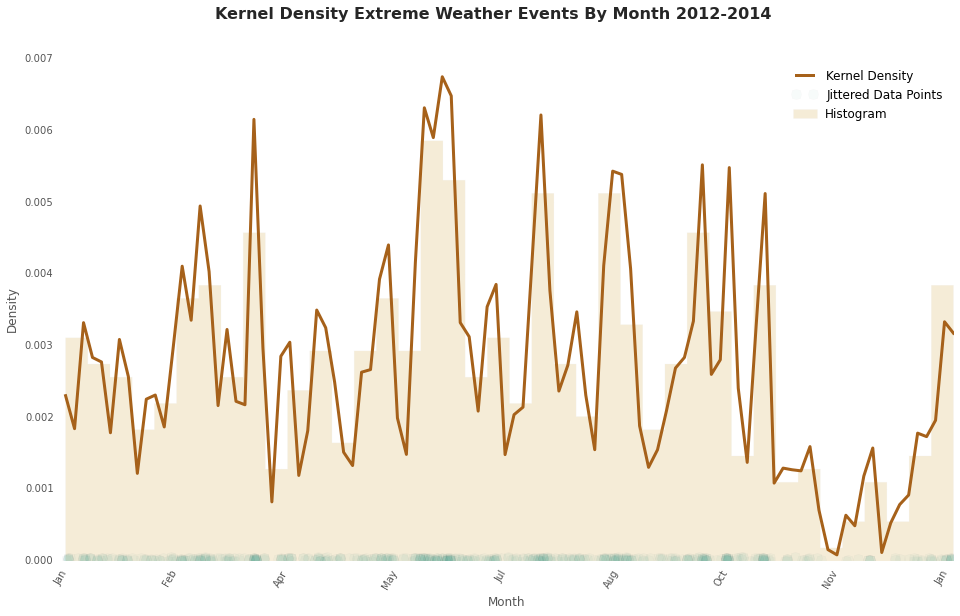

In [76]:
def convert_month(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + month + day

    
daily_ext = prox[prox.extreme == 1][['date','extreme']]
dates_ext = daily_ext.date.apply(lambda x: convert_month(x))
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Kernel Density Extreme Weather Events By Month 2012-2014',
             fontweight = 'bold', color = '#262626', fontsize = 16)

dates_ext = dates_ext.reshape(-1, 1)

kde = KernelDensity(bandwidth=2).fit(dates_ext)
x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
density = np.exp(kde.score_samples(x))

plt.plot(x, density, linewidth = 3, label = 'Kernel Density', color = colors[0])
plt.hist(dates_ext, bins = 40, color = colors[1], normed = True, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')
plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
         ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')


plt.ylim(0, 0.007)
plt.xlim([0, 365])

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

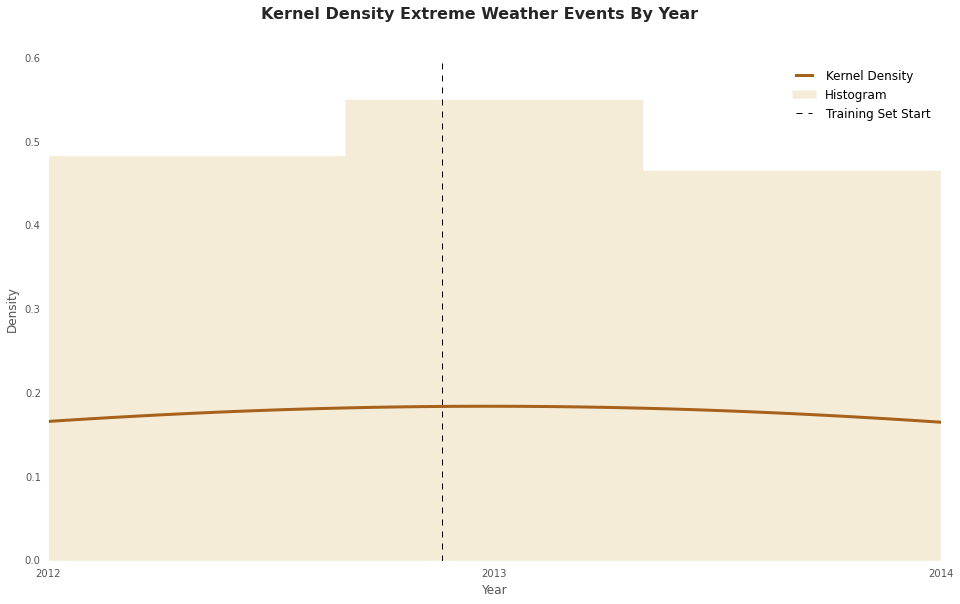

In [77]:
daily_ext = prox[prox.extreme == 1][['date','extreme']]
dates_ext = daily_ext.date.apply(lambda x: x.year - 2012).values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Kernel Density Extreme Weather Events By Year',
             fontweight = 'bold', color = '#262626', fontsize = 16)

dates_ext = dates_ext.reshape(-1, 1)

kde = KernelDensity(bandwidth=2).fit(dates_ext)
x = np.linspace(0, 2, 100).reshape(-1, 1)
density = np.exp(kde.score_samples(x))

plt.plot(x, density, linewidth = 3, label = 'Kernel Density', color = colors[0])
plt.hist(dates_ext, bins = 3, color = colors[1], normed = True, cumulative = False, 
     histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')
plt.vlines(456./1034.*2, 0, 0.6, linestyles = '--', label = 'Training Set Start')

# plt.ylim(0, 0.007)
# plt.xlim([0, 365])

plt.xlabel('Year')
plt.ylabel("Density")

# xaxis = [2012 + i for i in np.arange(0,3,1)]
# xvals = np.arange(0,3,1)
plt.xticks([0, 1, 2], [2012, 2013, 2014], rotation = 0, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

## It appears extreme events are more common in the summer -- being in NY, intuition would suggest that the winter would have the bulk of the extreme weather events. This suggests that we might want to cluster weather event types, or cluster stations as being in certain climates

# IDEA: have different models for the different weather types, or different climates/stations

In [82]:
def grid_kernel(sn):
    def convert_month(x):
        year = x.year - 2012
        month = month_days[x.month]
        day = x.day

        if x < date(2012, 2, 29):
            return month + day
        else:
            return 1 + month + day

    daily_ext = prox[np.logical_and(prox.extreme == 1, prox.station_nbr == sn)][['date','extreme']]
    dates_ext = daily_ext.date.apply(lambda x: convert_month(x))

    dates_ext = dates_ext.reshape(-1, 1)

    ax = plt.subplot(5, 4, sn)

    kde = KernelDensity(bandwidth=2).fit(dates_ext)
    x = np.linspace(dates_ext.min(), dates_ext.max(), 100).reshape(-1, 1)
    density = np.exp(kde.score_samples(x))

    plt.plot(x, density, linewidth = 3, label = 'Kernel Density', color = colors[0])
    # plt.hist(dates_ext, bins = 13, color = colors[1], normed = True, cumulative = False, 
    #      histtype = 'stepfilled', alpha = 0.30, label = 'Histogram')
    plt.plot(dates_ext, abs(np.random.rand(len(dates_ext), 1)/20000), 'ok', \
             ms=10, alpha=.03, color = colors[3], label = 'Jittered Data Points')

    ax.set_title('Station ' + str(sn))
    plt.ylim(0, density.max())
    plt.xlim([0, 365])

    if sn == 1:
        plt.xlabel('Month')
        plt.ylabel('Density')
        month_d={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', \
                 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', \
                 11:'Nov', 12:'Dec'}
        xaxis = [month_d[(daily_ext.date.min() + timedelta(days = i)).month] for i in np.arange(0,365,45)]
        xvals = np.arange(0,365,45)
        plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)
    else:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    for label in ax.get_yticklabels():
        label.set_visible(False)  
        


    for label in ax.get_xticklines():
        label.set_visible(False)
    for label2 in ax.get_yticklines():
        label2.set_visible(False)

#     ax.legend(loc = 'best')



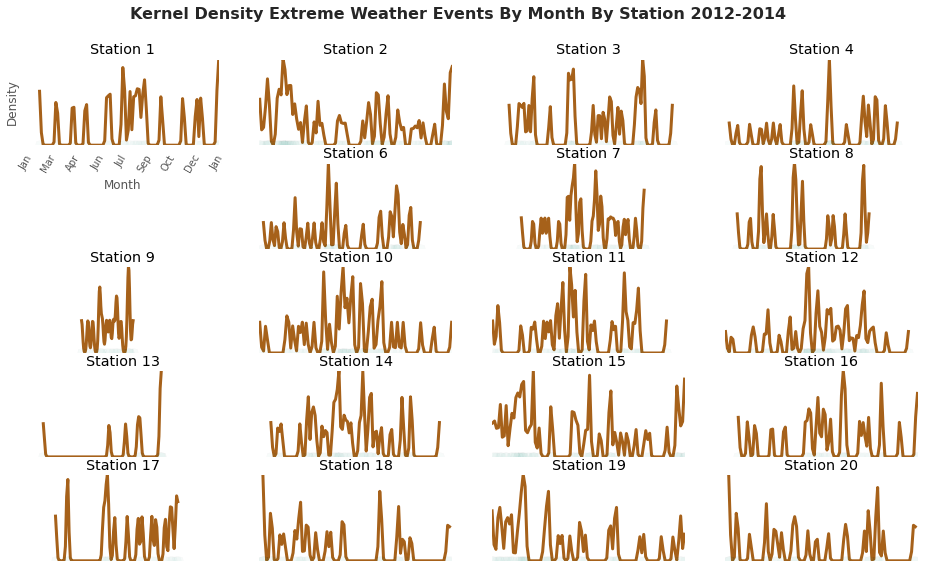

In [83]:
sn = 1
fig = plt.figure(figsize = (16,9))
plt.suptitle('Kernel Density Extreme Weather Events By Month By Station 2012-2014',
             fontweight = 'bold', color = '#262626', fontsize = 16)

for sn in np.arange(1, 21, 1):
    if sn != 5:
        grid_kernel(sn)

plt.show()

## We can see the distinct climates, e.g. Station 9 has only extreme weather events in the summer, whereas Station 2 has more extreme weather events in the window

# Join weather with training and test sets

In [85]:
# weather.to_csv('weather_features02.csv')
# train.to_csv('train_c.csv')
# test.to_csv('test_c.csv')

# --------------------

### Many items have no sales -- take a look at proportion of days with sales by item (right axis - average sales)

In [86]:
all_train = train.merge(weather, on = ['station_nbr','date'])

In [151]:
item_sales = all_train[['units','item_nbr']]
days_with_sales = item_sales.copy()
days_with_sales.loc[:, 'units'] = days_with_sales.loc[:, 'units'].apply(lambda x: 1 if x > 0 else 0)

days_with_sales_possible = days_with_sales.groupby('item_nbr').count()
days_with_sales_possible.columns = ['days_possible']
days_with_sales = days_with_sales.groupby('item_nbr').sum()
days_with_sales.columns = ['days_w_sales']
total_sales = item_sales.groupby('item_nbr').sum()
total_sales.columns = ['total_sales']

In [152]:
sales = total_sales.merge(days_with_sales, left_index = True, right_index = True).merge(days_with_sales_possible, left_index = True, right_index = True)
sales.head(2)

,total_sales,days_w_sales,days_possible
item_nbr,,,
1,778,303,40749
2,3269,884,40749


In [153]:
sales.loc[:, 'total_sales'] = (sales.loc[:, 'total_sales'].apply(lambda x: float(x)) / sales.loc[:, 'days_possible'])\
    .apply(lambda x: float(x))

In [154]:
sales.loc[:, 'days_w_sales'] = sales.loc[:, 'days_w_sales'].apply(lambda x: float(x)) / sales.loc[:, 'days_possible']\
    .apply(lambda x: float(x))

In [171]:
def sales_bars(sales, name, sort = False):
    fig = plt.figure(figsize = (16, 8))
    ax = plt.subplot(111)

    # x = np.arange(1,len(m.index)+1,1)
    x = np.arange(1,len(sales.index)+1,1)
    width = 0.75

    colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

    if name == 'prop':
        bar = plt.bar(x+width/2, sales.iloc[:, 1], width/2, color = colors[3], label = 'Proportion Days w/ Sales')
        plt.ylabel('Proportion of Days by Item')
        plt.suptitle('Proportion Days w/ Sales', 
                     fontsize = 14, fontweight = 'bold', color = '#262626')
    else:
        bar2 = plt.bar(x, sales.iloc[:, 0], width/2, color = colors[0], label = 'Sales Per Day')
        plt.ylabel('Sales/Day')
        plt.suptitle('Sales Per Day by Item', 
                     fontsize = 14, fontweight = 'bold', color = '#262626')

    for label in ax.get_xticklines():
        label.set_visible(False)

    for label in ax.get_yticklines():
        label.set_visible(False)

    skip = 5
#     plt.xticks(range(width/2, len([int(i) for i in np.arange(1,111,skip)])+width/2),[int(i) for i in np.arange(1,111,skip)], fontsize = 12, rotation = 90)
    if sort == False:
        plt.xlabel('Item #')
    else:
        plt.xlabel('Rank')
    x = plt.xlim([1, 112])

#     legend = ax.legend(loc = 'best')
#     legend = plt.legend(frameon = 2)
#     frame = legend.get_frame()
#     frame.set_color('lightgray')
#     frame.set_edgecolor('black') 

    plt.show()

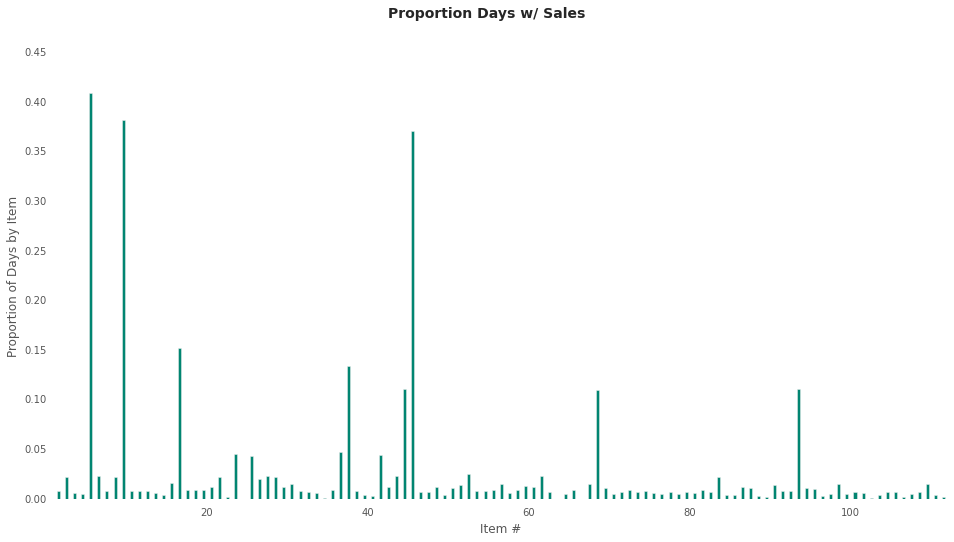

In [172]:
sales_bars(sales, 'prop')

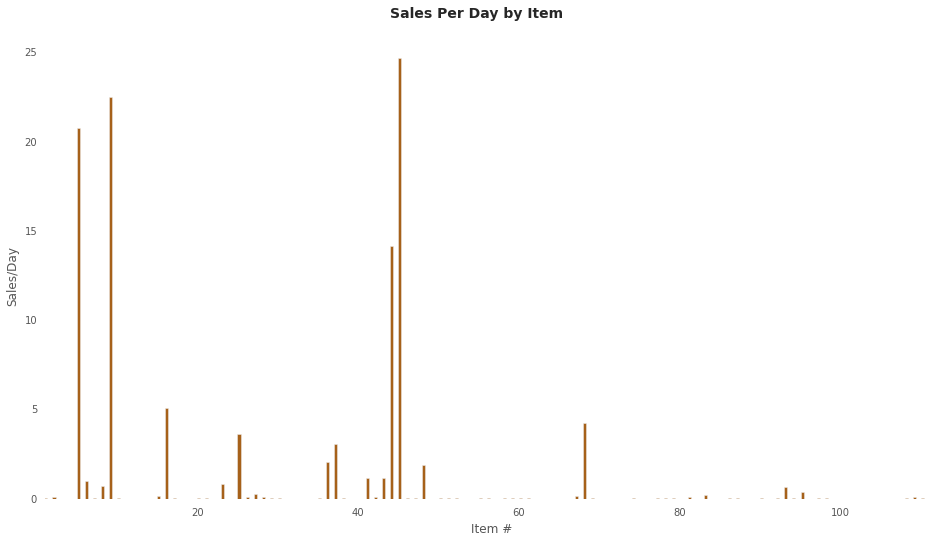

In [173]:
sales_bars(sales, 'total')

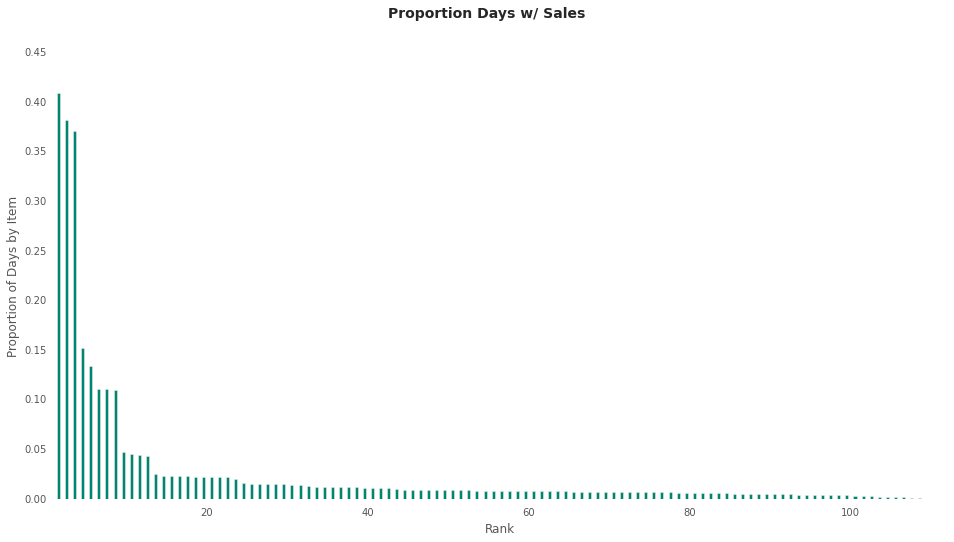

In [177]:
sales_bars(sales.sort('days_w_sales', ascending = False), 'prop', True)

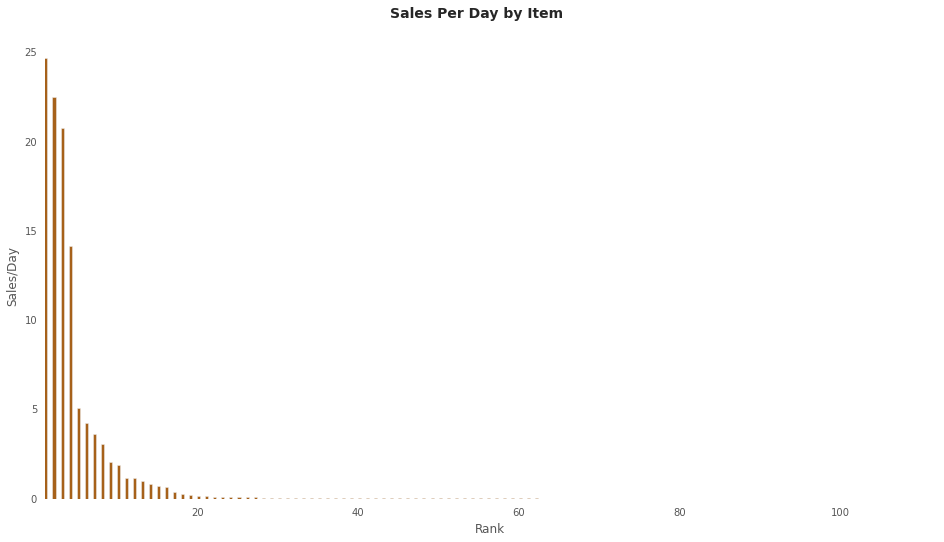

In [176]:
sales_bars(sales.sort('total_sales', ascending = False), 'total', True)

## We can see the long tail, with a few items making up most of the sales

### We will most likely predict 0 sales for the majority of items in the test set

* ### scatter plot of sales ... x-axis item (jittered), y-axis sales line-items
    

In [424]:
all_train.head(2)

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,rain_codes,extreme,store_date,ext_-3,ext_-2,ext_-1,ext_1,ext_2,ext_3,all_extreme
0,2012-01-01,1,1,0,1,52,31,42,NaN,36,...,1,0,1.0_2012-01-01,0,0,0,0,0,0,0
1,2012-01-01,1,2,0,1,52,31,42,NaN,36,...,1,0,1.0_2012-01-01,0,0,0,0,0,0,0


In [425]:
sales_all = all_train[['item_nbr','units','date']]

In [426]:
item_date_sales = sales_all.groupby(['item_nbr', 'date']).sum()
item_date_sales.tail(2)

units
item_nbr date             
111      2014-10-30      3
         2014-10-31      2

In [427]:
date_sales.head(2)

,units,date
date,,
2012-01-01,1.351556,2012-01-01
2012-01-02,1.597461,2012-01-02


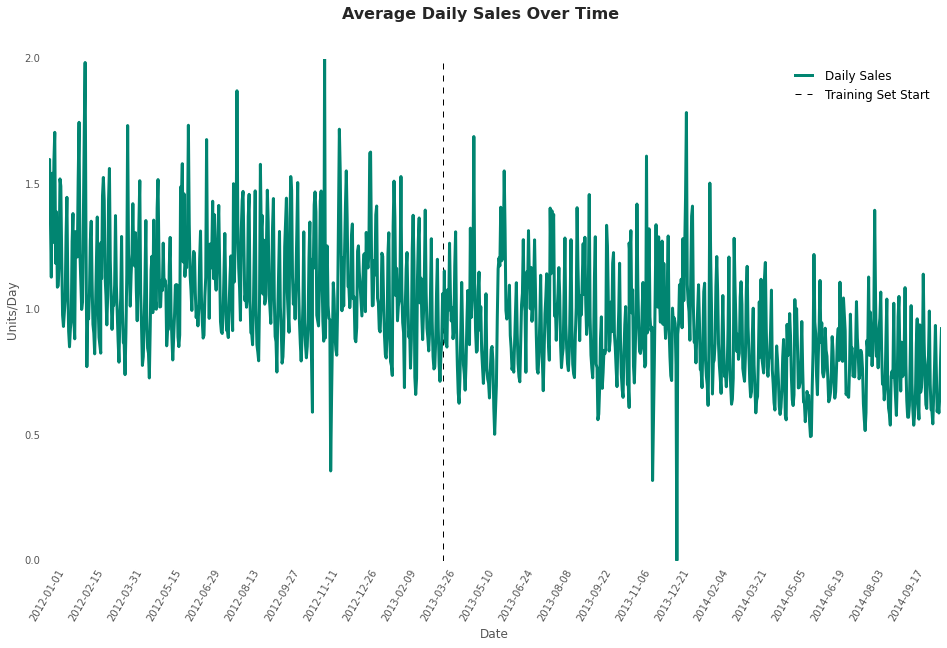

In [428]:
date_sales = sales_all[['units','date']].groupby(['date']).mean()
date_sales['date'] = date_sales.index
daily_sales = date_sales.units.values
dates_sales = date_sales.date.apply(lambda x: convert_date(x)).values

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Average Daily Sales Over Time', fontweight = 'bold', color = '#262626', fontsize = 16)

plt.vlines((test.date.min() - train.date.min()).days, 0, max(daily_sales), \
           linestyles = '--', label = 'Training Set Start')
plt.plot(dates_sales, daily_sales, linewidth = 3, label = 'Daily Sales', color = colors[3])
plt.xlim([0, 1029])

plt.xlabel('Date')
plt.ylabel("Units/Day")

xaxis = [date_sales.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
xvals = np.arange(0,1030,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')
    
plt.show()

## Note: it seems a spike in sales is typically followed by a dip several says after... this makes sense, as the item may be out of stock and people have already purchased a surplus of that item.

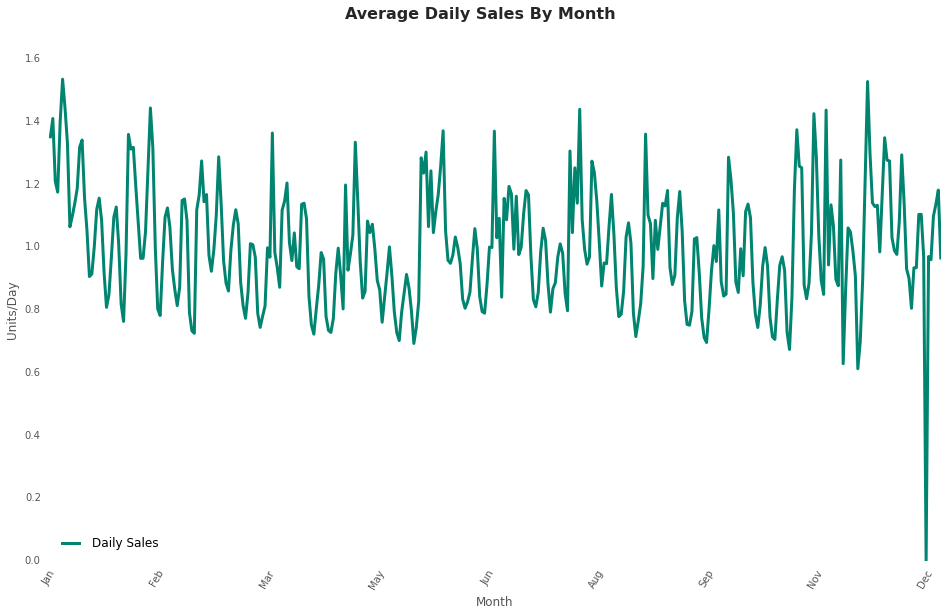

In [429]:
def convert_month(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + month + day

date_sales = sales_all[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: convert_month(x)).values

date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index

daily_sales = date_sales.units.values
dates_sales = date_sales.date.values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Average Daily Sales By Month',
             fontweight = 'bold', color = '#262626', fontsize = 16)

plt.plot(dates_sales, daily_sales, label = 'Daily Sales', linewidth = 3, color = colors[3])

plt.xlim([0, 366])

plt.xlabel('Month')
plt.ylabel("Units/Day")

month_d={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', \
         6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', \
         11:'Nov', 12:'Dec'}
xaxis = [month_d[(sales_all.date.min() + timedelta(days = i)).month] for i in np.arange(0,365,45)]
xvals = np.arange(0,365,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)
    
ax.legend(loc = 'best')

plt.show()

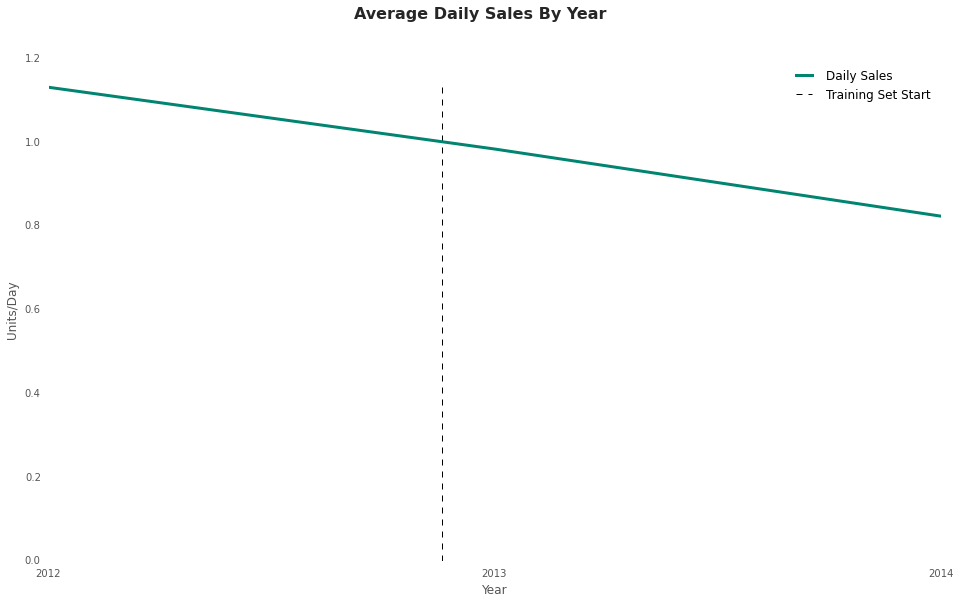

In [430]:
date_sales = sales_all[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.year - 2012).values

date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Average Daily Sales By Year',
             fontweight = 'bold', color = '#262626', fontsize = 16)

plt.plot(date_sales.date.values, date_sales.units.values, linewidth = 3, label = 'Daily Sales', color = colors[3])
plt.vlines(456./1034.*2, 0, max(date_sales.units.values), linestyles = '--', label = 'Training Set Start')

# plt.ylim(0, 0.007)
plt.xlim([0, 2])

plt.xlabel('Year')
plt.ylabel("Units/Day")

plt.xticks([0, 1, 2], [2012, 2013, 2014], rotation = 0, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

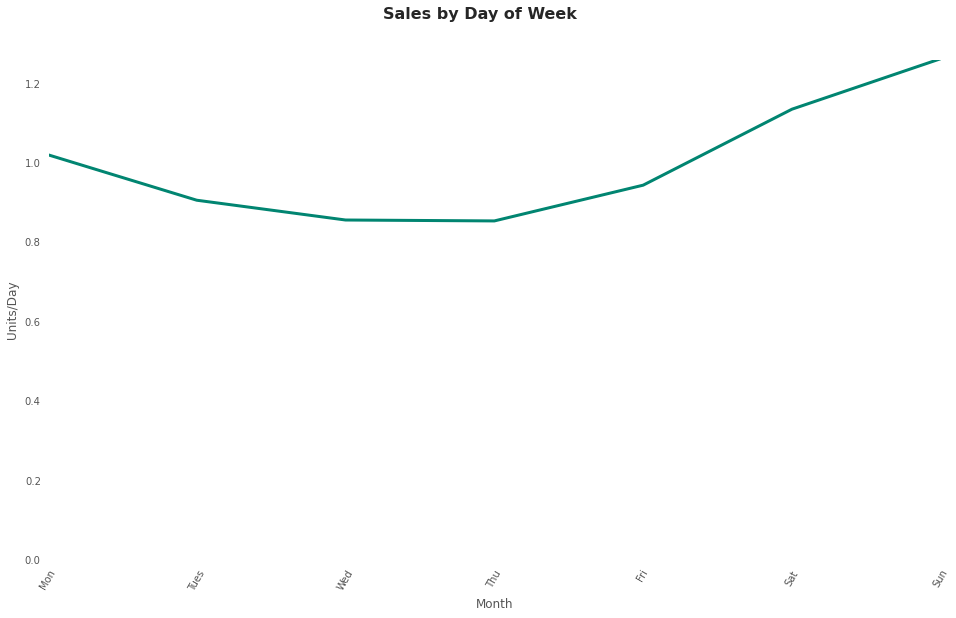

In [431]:
date_sales = sales_all[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.weekday()).values

date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index

daily_sales = date_sales.units.values
dates_sales = date_sales.date.values
# daily_ext = daily_ext.drop('idx', 1)

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Sales by Day of Week',
             fontweight = 'bold', color = '#262626', fontsize = 16)

plt.plot(dates_sales, daily_sales, linewidth = 3, color = colors[3])

plt.ylim([0, max(daily_sales)])
plt.xlim([0, 6])

plt.xlabel('Month')
plt.ylabel("Units/Day")

month_d={ 0:'Mon', 1:'Tues', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun' }
xaxis = [month_d[i] for i in np.arange(0,7,1)]
xvals = np.arange(0,7,1)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

plt.show()

In [432]:
train_stormy = all_train[all_train.all_extreme > 0][['item_nbr','units','date']]
train_not = all_train[all_train.all_extreme == 0][['item_nbr','units','date']]

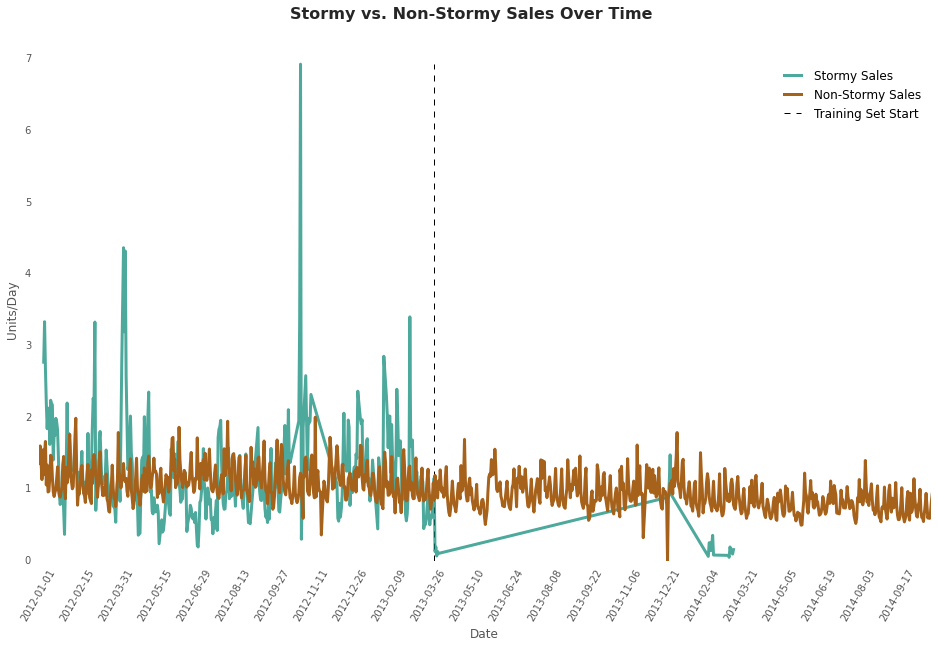

In [433]:
fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Stormy vs. Non-Stormy Sales Over Time', fontweight = 'bold', color = '#262626', fontsize = 16)

date_sales_s = train_stormy[['units','date']].groupby(['date']).mean()
date_sales_s['date'] = date_sales_s.index
daily_sales_s = date_sales_s.units.values
dates_sales_s = date_sales_s.date.apply(lambda x: convert_date(x)).values
plt.plot(dates_sales_s, daily_sales_s, linewidth = 3, alpha = 0.7, label = 'Stormy Sales', color = colors[3])

date_sales_n = train_not[['units','date']].groupby(['date']).mean()
date_sales_n['date'] = date_sales_n.index
daily_sales_n = date_sales_n.units.values
dates_sales_n = date_sales_n.date.apply(lambda x: convert_date(x)).values
plt.plot(dates_sales_n, daily_sales_n, linewidth = 3, label = 'Non-Stormy Sales', color = colors[0])

plt.vlines((test.date.min() - train.date.min()).days, 0, max(daily_sales_s), \
           linestyles = '--', label = 'Training Set Start')
plt.xlim([0, 1029])

plt.xlabel('Date')
plt.ylabel("Units/Day")

xaxis = [date_sales_n.date.min() + timedelta(days = i) for i in np.arange(0,1030,45)]
xvals = np.arange(0,1030,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')
    
plt.show()

In [438]:
date_sales_s = train_stormy[['units','date']].groupby(['date']).mean()

print date_sales_s.units.mean()
date_sales_s.sort('units', ascending = False).head(10)

1.1794699178


,units
date,
2012-10-28,6.918919
2012-04-07,4.360360
2012-04-09,4.315315
2012-04-06,3.567568
2013-03-03,3.396396
2012-01-07,3.328829
2012-03-05,3.324324
2012-10-27,3.315315
2012-04-08,3.189189


In [451]:
print date_sales_s.loc[date(2012, 10, 26):date(2012, 11, 10), 'units']

date
2012-10-26    1.945946
2012-10-27    3.315315
2012-10-28    6.918919
2012-10-29    0.297297
2012-10-30    0.972973
2012-10-31    0.666667
2012-11-01    1.846847
2012-11-04    2.576577
2012-11-05    1.882883
2012-11-06    1.261261
2012-11-07    1.981982
2012-11-08    1.918919
2012-11-09    1.945946
2012-11-10    2.315315
Name: units, dtype: float64


## Notice the Sandy spike... this may be an outlier that should be removed given the extremity of the storm

* ### Sandy hit NY/NJ on October 29. There was a sales increase on October 27, and then the highest sales in the training set on October 28. Unsurprisingly, the sales the following 3 days were much lower, and then returned to roughly normal levels
* ### In March 2012 and again in April 2012, there was a tornado outbreak. Could these sales spikes be related to this?

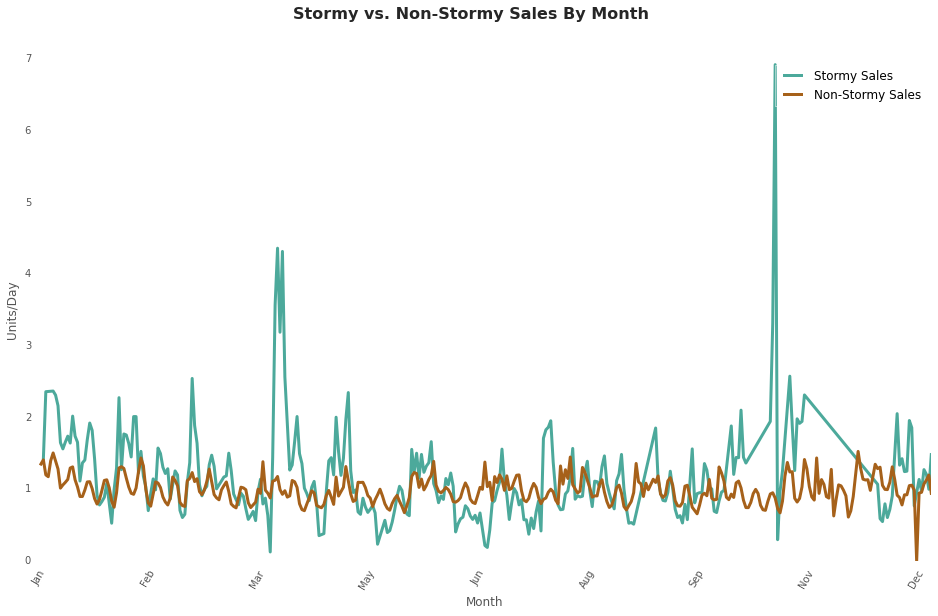

In [452]:
def convert_month(x):
    year = x.year - 2012
    month = month_days[x.month]
    day = x.day
    
    if x < date(2012, 2, 29):
        return month + day
    else:
        return 1 + month + day

fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Stormy vs. Non-Stormy Sales By Month',
             fontweight = 'bold', color = '#262626', fontsize = 16)    

date_sales = train_stormy[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: convert_month(x)).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
daily_sales = date_sales.units.values
dates_sales = date_sales.date.values
plt.plot(dates_sales, daily_sales, label = 'Stormy Sales', alpha = 0.7, linewidth = 3, color = colors[3])

date_sales = train_not[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: convert_month(x)).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
daily_sales = date_sales.units.values
dates_sales = date_sales.date.values
plt.plot(dates_sales, daily_sales, label = 'Non-Stormy Sales', linewidth = 3, color = colors[0])

plt.xlim([0, 366])

plt.xlabel('Month')
plt.ylabel("Units/Day")

month_d={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', \
         6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', \
         11:'Nov', 12:'Dec'}
xaxis = [month_d[(sales_all.date.min() + timedelta(days = i)).month] for i in np.arange(0,365,45)]
xvals = np.arange(0,365,45)
plt.xticks(xvals, xaxis, rotation = 60, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)
    
ax.legend(loc = 'best')

plt.show()

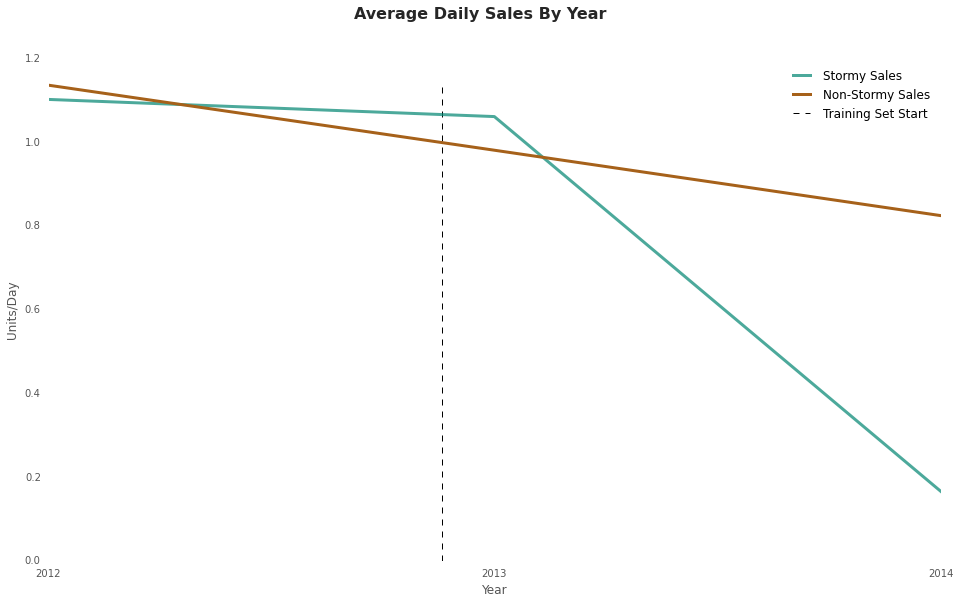

In [453]:
fig = plt.figure(figsize = (16,9))
ax = plt.subplot(111)
plt.suptitle('Average Daily Sales By Year',
             fontweight = 'bold', color = '#262626', fontsize = 16)

date_sales = train_stormy[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.year - 2012).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
plt.plot(date_sales.date.values, date_sales.units.values, linewidth = 3, alpha = 0.7, label = 'Stormy Sales', color = colors[3])

date_sales = train_not[['units','date']]
date_sales.loc[:, 'date'] = date_sales.date.apply(lambda x: x.year - 2012).values
date_sales = date_sales.groupby(['date']).mean()
date_sales['date'] = date_sales.index
plt.plot(date_sales.date.values, date_sales.units.values, linewidth = 3, label = 'Non-Stormy Sales', color = colors[0])

plt.vlines(456./1034.*2, 0, max(date_sales.units.values), linestyles = '--', label = 'Training Set Start')

# plt.ylim(0, 0.007)
plt.xlim([0, 2])

plt.xlabel('Year')
plt.ylabel("Units/Day")

plt.xticks([0, 1, 2], [2012, 2013, 2014], rotation = 0, fontsize = 10)

for label in ax.get_xticklines():
    label.set_visible(False)
for label2 in ax.get_yticklines():
    label2.set_visible(False)

ax.legend(loc = 'best')

plt.show()

In [454]:
all_set_dates = list(train.date.apply(lambda x: date(x.year, x.month, 1)).unique())
all_test_dates = list(test.date.apply(lambda x: date(x.year, x.month, 1)).unique())
all_set_dates.extend(all_test_dates)
all_set_dates = list(set(all_set_dates))

In [455]:
stormy_dates = stormy_dates.groupby('date').count()

In [456]:
train_stormy = all_train[all_train.all_extreme > 0][['date', 'store_nbr']].drop_duplicates()
train_not = all_train[all_train.all_extreme == 0][['date', 'store_nbr']].drop_duplicates()
test_stormy = test[['date', 'store_nbr']].drop_duplicates()

In [457]:
train_stormy.loc[:, 'date'] = train_stormy.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))
train_not.loc[:, 'date'] = train_not.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))
test_stormy.loc[:, 'date'] = test_stormy.loc[:, 'date'].apply(lambda x: date(x.year, x.month, 1))

In [458]:
train_stormy = train_stormy.groupby('date').count()
train_not = train_not.groupby('date').count()
test_stormy = test_stormy.groupby('date').count()

In [459]:
storms = {}
for i in all_set_dates:
    storms[i] = []
    for df in [ train_stormy, train_not, test_stormy ]:
        if i in df.index:
            storms[i].append( df.loc[i, 'store_nbr'] )
        else:
            storms[i].append(0)

In [460]:
storms = DataFrame.from_dict(storms, orient = 'index')
storms.columns = 'train_stormy', 'train_not', 'test_stormy'

In [461]:
storms['total'] = storms[['train_stormy', 'train_not', 'test_stormy']].sum(axis = 1)
storms.sort_index(inplace = True)

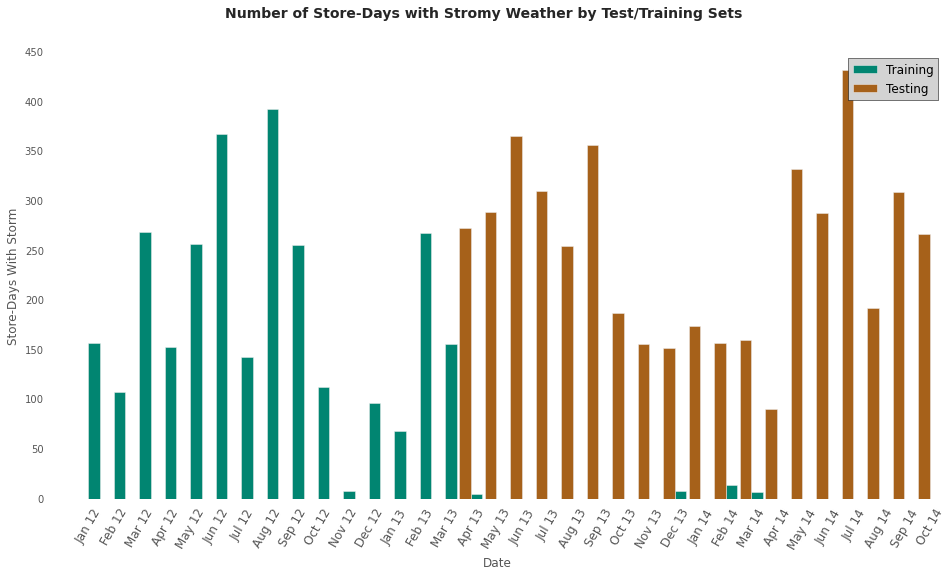

In [462]:
fig = plt.figure(figsize = (16, 8))
ax = plt.subplot(111)

x = np.arange(1,len(storms.index)+1,1)
width = 0.9

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x+width/2, storms.iloc[:, 0], width/2, color = colors[3], label = 'Training')
bar2 = plt.bar(x, storms.iloc[:, 2], width/2, color = colors[0], label = 'Testing')

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2,[i.strftime('%b %y') for i in storms.index], fontsize = 12, rotation = 60)
plt.xlabel('Date')
plt.ylabel('Store-Days With Storm')
plt.suptitle('Number of Store-Days with Stromy Weather by Test/Training Sets', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
# x = plt.xlim([1, 21])

legend = ax.legend(loc = 'best')
legend = plt.legend(frameon = 2)
frame = legend.get_frame()
frame.set_color('lightgray')
frame.set_edgecolor('black') 

plt.show()

## Conclusion: the training set stormy days and test set stormy days come from almost completely disjoint time periods, meaning we'll need to factor in date when modeling

### Secondary conclusion: we have to model the extremity of the weather. In the above plot, Sandy (Oct '12) cannot be noticed but we saw a massive spike in sales

## Ideas:
- model log units
- oversample/understample time/stores
- normalize for time (divide out some weight)
- US holidays
- inspect 0s
- model the dip followed by spike
- ?? model correlation between the highest selling days and the weather $\rightarrow$ what types of weather are associated with high sales?

## difference between sales for given products between stormy and non-stormy, ending March 26, 2013

* ### Weather-sensitive store/items: averages with/without storm


## Plots:
* ### test/train skew in date, store, item 
* ### scatter matrix by item and by store
* ### Heatmap of store-item sales?